FINAL PIPELINE 

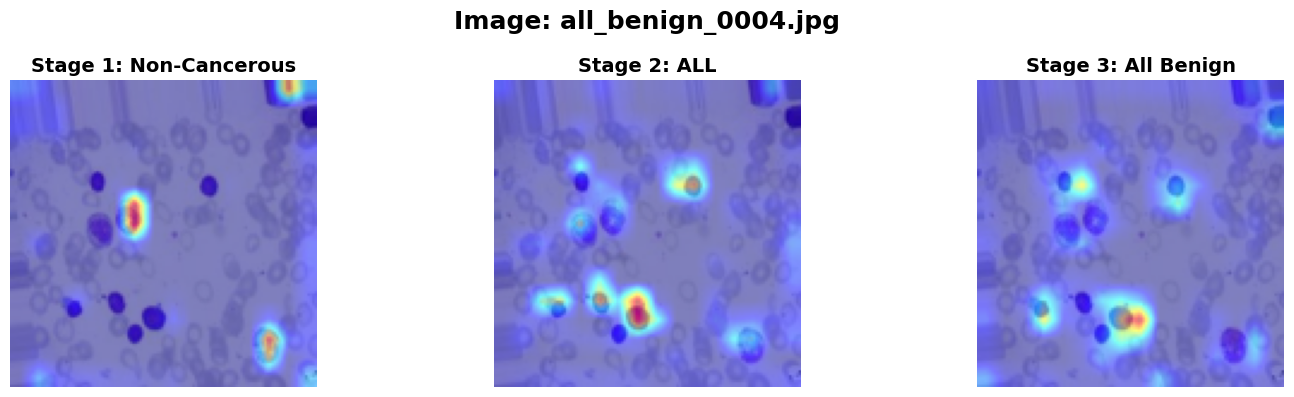


Result for: all_benign_0004.jpg
Cancerous: False
Predicted Cancer Type: ALL
Predicted Subtype: All Benign




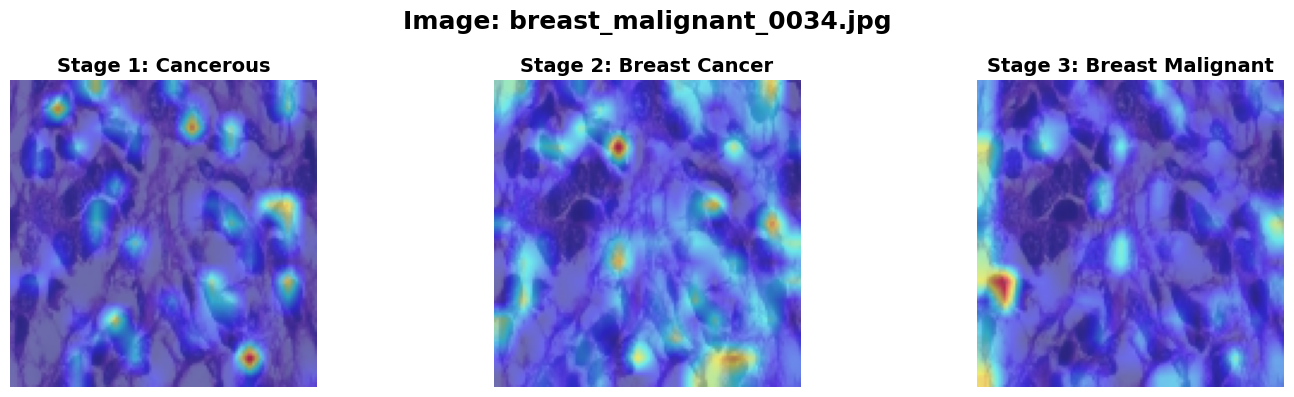


Result for: breast_malignant_0034.jpg
Cancerous: True
Predicted Cancer Type: Breast Cancer
Predicted Subtype: Breast Malignant




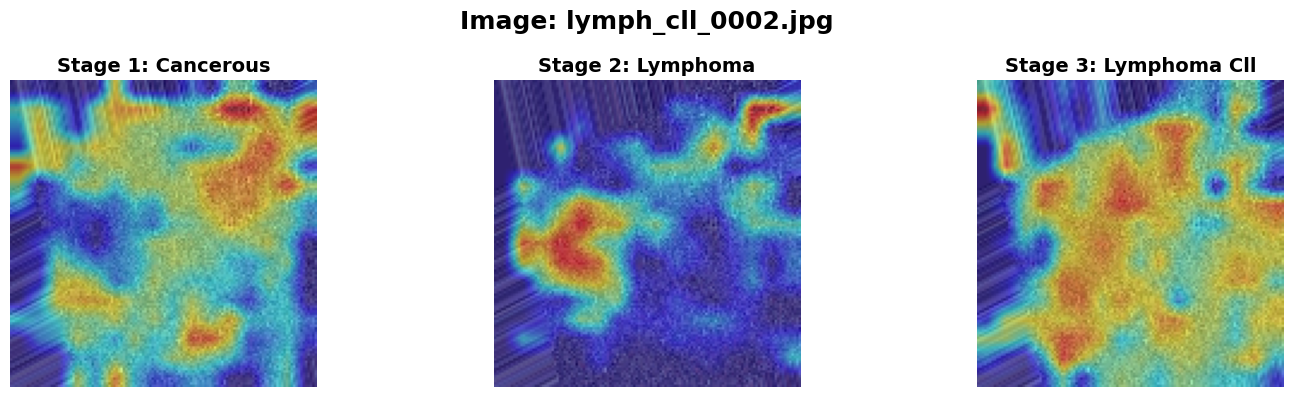


Result for: lymph_cll_0002.jpg
Cancerous: True
Predicted Cancer Type: Lymphoma
Predicted Subtype: Lymphoma Cll




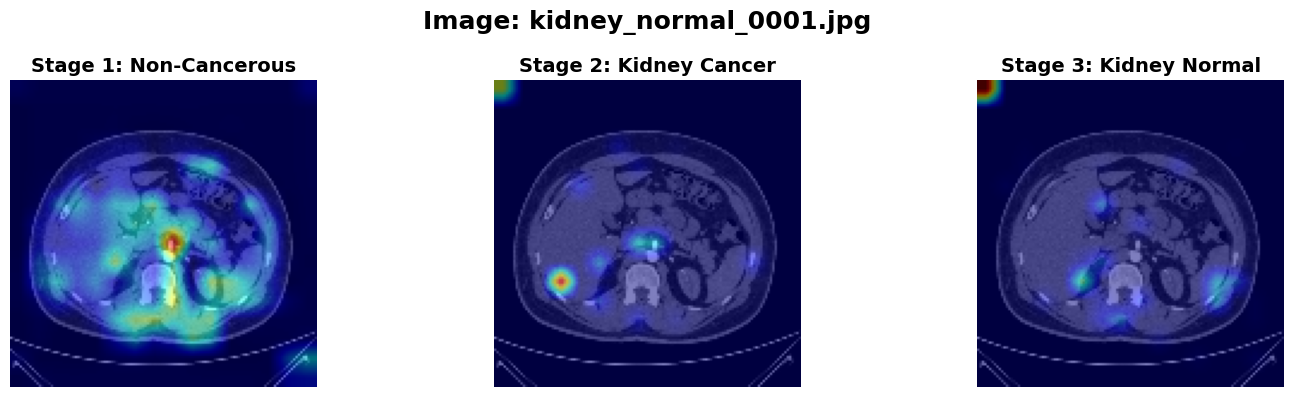


Result for: kidney_normal_0001.jpg
Cancerous: False
Predicted Cancer Type: Kidney Cancer
Predicted Subtype: Kidney Normal




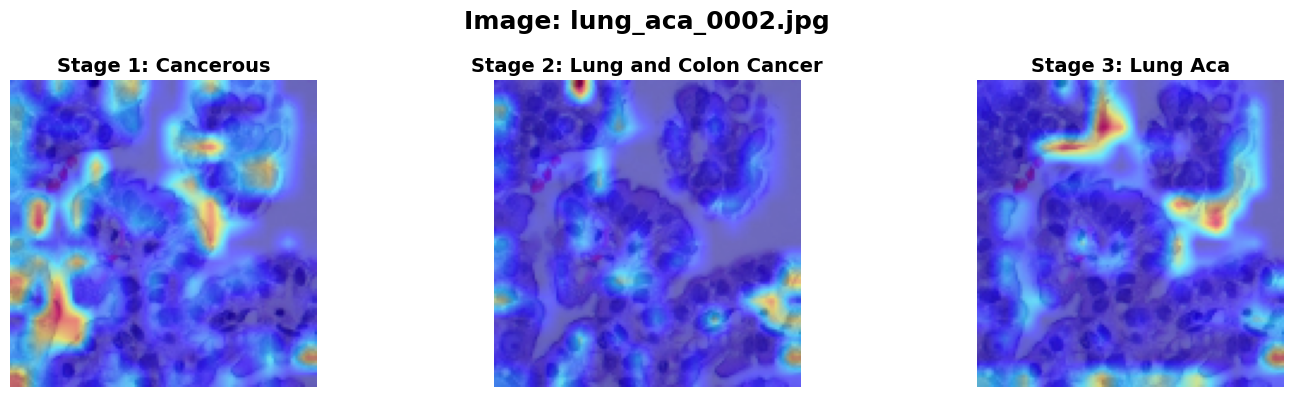


Result for: lung_aca_0002.jpg
Cancerous: True
Predicted Cancer Type: Lung and Colon Cancer
Predicted Subtype: Lung Aca




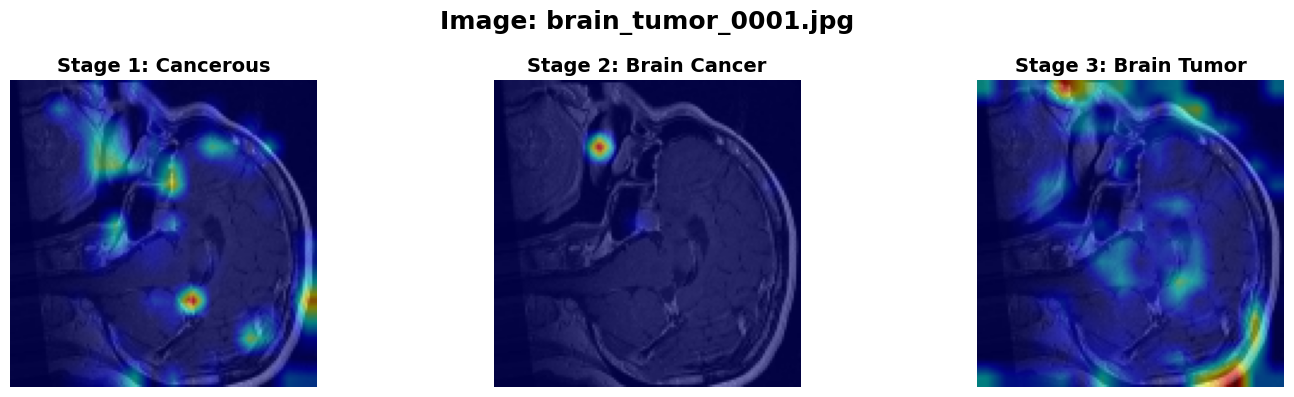


Result for: brain_tumor_0001.jpg
Cancerous: True
Predicted Cancer Type: Brain Cancer
Predicted Subtype: Brain Tumor




In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Preprocessing ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Stage 1 Model (Binary Classifier with 2 outputs) ===
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        self.activations = x
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model_stage1 = CancerCNN().to(device)
model_stage1.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/binary_cancer_cnn.pth", map_location=device))
model_stage1.eval()

# === Stage 2 Model ===
class Stage2TypeClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(Stage2TypeClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        self.activations = x
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model_stage2 = Stage2TypeClassifier(num_classes=8).to(device)
model_stage2.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/organ_classifier_cnn (1).pth", map_location=device))
model_stage2.eval()

stage2_classes = [
    "ALL", "Brain Cancer", "Breast Cancer", "Cervical Cancer",
    "Kidney Cancer", "Lung and Colon Cancer", "Lymphoma", "Oral Cancer"
]

# === Stage 3 Model ===
class Stage3SubtypeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(Stage3SubtypeClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        self.activations = x
        x = x.view(x.size(0), -1)
        return self.classifier(x)

stage3_classes = sorted([
    "all_benign", "all_early", "all_pre", "all_pro",
    "brain_glioma", "brain_meningioma", "brain_tumor",
    "breast_benign", "breast_malignant",
    "cervix_dyk", "cervix_koc", "cervix_mep", "cervix_pab", "cervix_sfi",
    "kidney_normal", "kidney_tumor",
    "colon_aca", "colon_bnt", "lung_aca", "lung_bnt", "lung_scc",
    "lymphoma_cll", "lymphoma_fl", "lymphoma_mcl",
    "oral_normal", "oral_scc"
])

model_stage3 = Stage3SubtypeClassifier(num_classes=len(stage3_classes)).to(device)
model_stage3.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/cancer_cnn.pth", map_location=device))
model_stage3.eval()

# === Grad-CAM Function ===
def generate_gradcam(model, image_tensor, class_index):
    gradients = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    handle = model.features.register_full_backward_hook(backward_hook)
    output = model(image_tensor)
    output[0, class_index].backward()
    grads = gradients[0].detach()
    activations = model.activations.detach()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    for i in range(min(activations.shape[1], pooled_grads.shape[0])):
        activations[:, i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else np.zeros_like(heatmap)
    handle.remove()
    return heatmap

# === Overlay Heatmap ===
def overlay_heatmap(image_path, heatmap):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    heatmap = cv2.resize(heatmap, (128, 128))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return (heatmap_color * 0.5 + img * 0.5).astype(np.uint8)

# === Run Pipeline for Multiple Images ===
def run_batch_pipeline(image_paths):
    for image_path in image_paths:
        img_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

        output1 = model_stage1(img_tensor)
        probs = torch.softmax(output1, dim=1)
        is_cancer = torch.argmax(probs, dim=1).item() == 1
        heatmap1 = generate_gradcam(model_stage1, img_tensor.clone(), 1)
        vis1 = overlay_heatmap(image_path, heatmap1)

        output2 = model_stage2(img_tensor)
        pred2 = torch.argmax(output2, dim=1).item()
        organ_type = stage2_classes[pred2]
        heatmap2 = generate_gradcam(model_stage2, img_tensor.clone(), pred2)
        vis2 = overlay_heatmap(image_path, heatmap2)

        output3 = model_stage3(img_tensor)
        pred3 = torch.argmax(output3, dim=1).item()
        subtype = stage3_classes[pred3].replace("_", " ").title()
        heatmap3 = generate_gradcam(model_stage3, img_tensor.clone(), pred3)
        vis3 = overlay_heatmap(image_path, heatmap3)

        # Display heatmaps
        plt.figure(figsize=(15, 4))
        plt.suptitle(f"Image: {os.path.basename(image_path)}", fontsize=18, fontweight='bold')
        
        plt.subplot(1, 3, 1)
        plt.imshow(vis1[..., ::-1])
        plt.title("Stage 1: " + ("Cancerous" if is_cancer else "Non-Cancerous"), fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(vis2[..., ::-1])
        plt.title(f"Stage 2: {organ_type}", fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(vis3[..., ::-1])
        plt.title(f"Stage 3: {subtype}", fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print Results
        print("\n\033[1mResult for:\033[0m", os.path.basename(image_path))
        print("\033[94m" + "=" * 40 + "\033[0m")
        print(f"\033[92mCancerous: {is_cancer}\033[0m")
        print(f"\033[93mPredicted Cancer Type: {organ_type}\033[0m")
        print(f"\033[96mPredicted Subtype: {subtype}\033[0m")
        print("\n")

# === Example Usage ===
#ADD THE PATH OF IMAGES TO THE IMAGE LIST
image_list = [
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/ALL/all_benign/all_benign_0004.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer/breast_malignant/breast_malignant_0034.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lymphoma/lymph_cll/lymph_cll_0002.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0001.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_aca/lung_aca_0002.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_0001.jpg"
]
run_batch_pipeline(image_list)


In [7]:
# ✅ FINAL CANCER PIPELINE WITH METRICS LOGGING

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Preprocessing ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Model Definitions (3 stages) ===
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        self.activations = x
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class Stage2TypeClassifier(CancerCNN):
    def __init__(self, num_classes=8):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

class Stage3SubtypeClassifier(Stage2TypeClassifier):
    def __init__(self, num_classes):
        super().__init__(num_classes)

# === Load Models ===
model_stage1 = CancerCNN().to(device)
model_stage1.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/binary_cancer_cnn.pth", map_location=device))
model_stage1.eval()

model_stage2 = Stage2TypeClassifier(num_classes=8).to(device)
model_stage2.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/organ_classifier_cnn (1).pth", map_location=device))
model_stage2.eval()

stage2_classes = ["ALL", "Brain Cancer", "Breast Cancer", "Cervical Cancer", "Kidney Cancer", "Lung and Colon Cancer", "Lymphoma", "Oral Cancer"]

stage3_classes = sorted([
    "all_benign", "all_early", "all_pre", "all_pro",
    "brain_glioma", "brain_meningioma", "brain_tumor",
    "breast_benign", "breast_malignant",
    "cervix_dyk", "cervix_koc", "cervix_mep", "cervix_pab", "cervix_sfi",
    "kidney_normal", "kidney_tumor",
    "colon_aca", "colon_bnt", "lung_aca", "lung_bnt", "lung_scc",
    "lymphoma_cll", "lymphoma_fl", "lymphoma_mcl",
    "oral_normal", "oral_scc"
])

model_stage3 = Stage3SubtypeClassifier(num_classes=len(stage3_classes)).to(device)
model_stage3.load_state_dict(torch.load("/kaggle/input/stage3/pytorch/default/1/cancer_cnn.pth", map_location=device))
model_stage3.eval()

# === Grad-CAM (optional) ===
def generate_gradcam(model, image_tensor, class_index):
    gradients = []
    def hook(module, grad_in, grad_out): gradients.append(grad_out[0])
    h = model.features.register_full_backward_hook(hook)
    output = model(image_tensor)
    output[0, class_index].backward()
    grads = gradients[0].detach()
    activations = model.activations.detach()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    for i in range(min(activations.shape[1], pooled_grads.shape[0])):
        activations[:, i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else np.zeros_like(heatmap)
    h.remove()
    return heatmap

def overlay_heatmap(image_path, heatmap):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    heatmap = cv2.resize(heatmap, (128, 128))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return (heatmap_color * 0.5 + img * 0.5).astype(np.uint8)

# === Full Pipeline With Timing and CSV Logging ===
def run_batch_pipeline_with_metrics(image_paths, save_csv_path="pipeline_metrics.csv"):
    results = []

    for image_path in image_paths:
        img_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        base_name = os.path.basename(image_path)

        # === Stage 1 ===
        t1 = time.time()
        output1 = model_stage1(img_tensor)
        probs = torch.softmax(output1, dim=1)
        is_cancer = torch.argmax(probs, dim=1).item() == 1
        t1 = time.time() - t1

        # === Stage 2 ===
        if is_cancer:
            t2 = time.time()
            output2 = model_stage2(img_tensor)
            pred2 = torch.argmax(output2, dim=1).item()
            organ_type = stage2_classes[pred2]
            t2 = time.time() - t2

            # === Stage 3 ===
            t3 = time.time()
            output3 = model_stage3(img_tensor)
            pred3 = torch.argmax(output3, dim=1).item()
            subtype = stage3_classes[pred3]
            t3 = time.time() - t3
        else:
            organ_type = subtype = "-"
            t2 = t3 = 0.0

        results.append({
            "filename": base_name,
            "stage1_result": "cancer" if is_cancer else "non_cancer",
            "stage2_result": organ_type,
            "stage3_result": subtype,
            "time_stage1": round(t1, 4),
            "time_stage2": round(t2, 4),
            "time_stage3": round(t3, 4)
        })

    df = pd.DataFrame(results)
    df.to_csv(save_csv_path, index=False)
    print(f"\n✅ Results saved to {save_csv_path}")

    # Timing summary
    print("\n⏱ Average Inference Times:")
    for stage in ['time_stage1', 'time_stage2', 'time_stage3']:
        print(f"{stage}: {df[stage].mean():.4f} sec")

    # Optional class distribution
    print("\n📊 Stage 1 Class Distribution:")
    print(df['stage1_result'].value_counts())

    return df

# === Example Image Paths ===
image_list = [
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/ALL/all_benign/all_benign_0004.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer/breast_malignant/breast_malignant_0034.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lymphoma/lymph_cll/lymph_cll_0002.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0001.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_aca/lung_aca_0002.jpg",
    "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_0001.jpg"
]

# === Run Final Pipeline With Metrics ===
run_batch_pipeline_with_metrics(image_list)



✅ Results saved to pipeline_metrics.csv

⏱ Average Inference Times:
time_stage1: 0.0009 sec
time_stage2: 0.0005 sec
time_stage3: 0.0005 sec

📊 Stage 1 Class Distribution:
stage1_result
cancer        4
non_cancer    2
Name: count, dtype: int64


,filename,stage1_result,stage2_result,stage3_result,time_stage1,time_stage2,time_stage3
0,all_benign_0004.jpg,non_cancer,-,-,0.0011,0.0000,0.0000
1,breast_malignant_0034.jpg,cancer,Breast Cancer,breast_malignant,0.0009,0.0008,0.0008
2,lymph_cll_0002.jpg,cancer,Lymphoma,lymphoma_cll,0.0008,0.0007,0.0006
3,kidney_normal_0001.jpg,non_cancer,-,-,0.0009,0.0000,0.0000
4,lung_aca_0002.jpg,cancer,Lung and Colon Cancer,lung_aca,0.0008,0.0007,0.0007
5,brain_tumor_0001.jpg,cancer,Brain Cancer,brain_tumor,0.0008,0.0007,0.0007


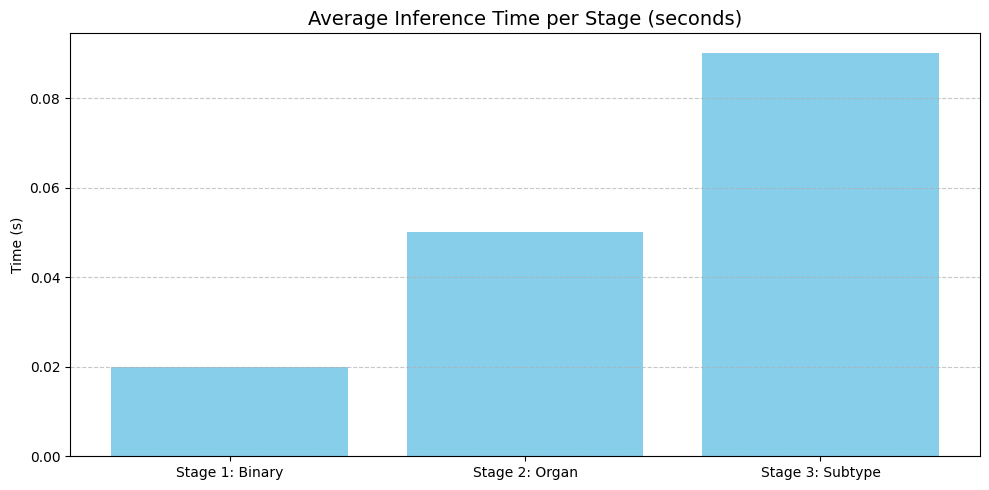

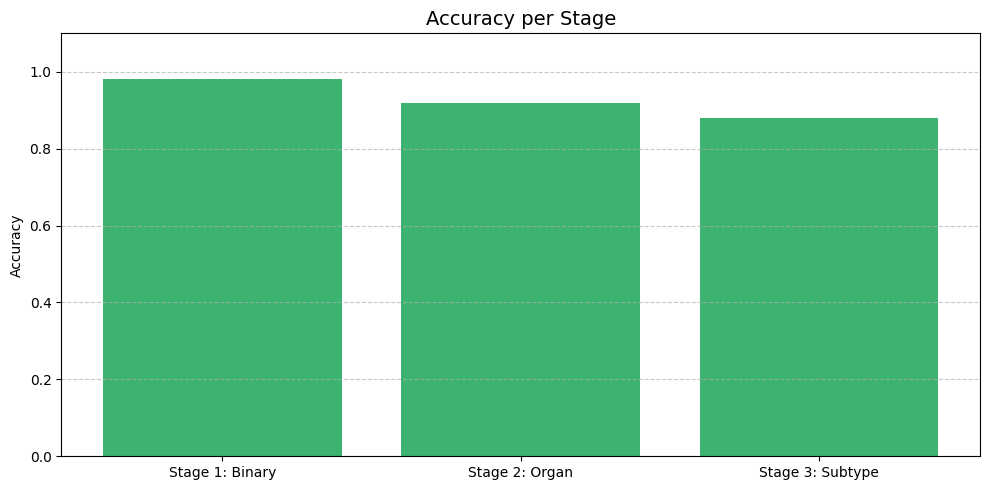

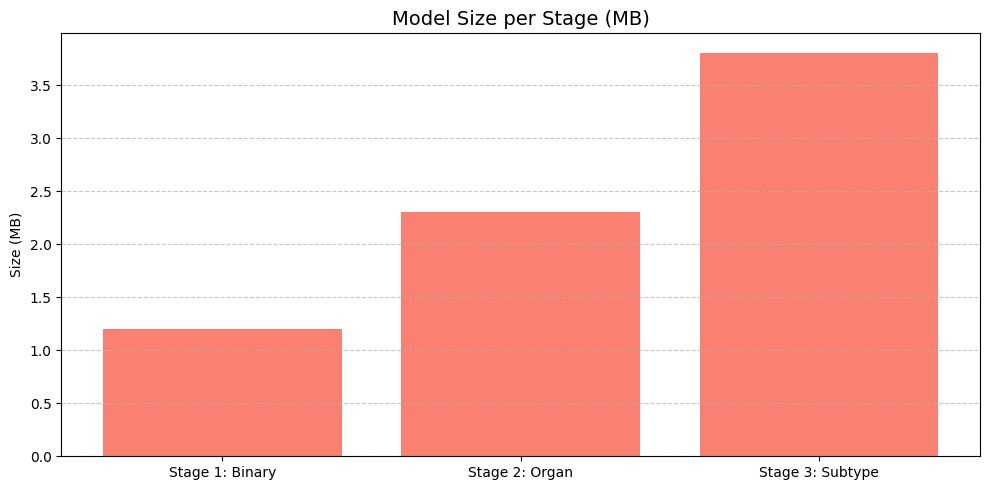

In [8]:
import matplotlib.pyplot as plt

# === Dummy Data (Replace with real values if needed) ===
inference_times = [0.02, 0.05, 0.09]  # Seconds for Stage 1, 2, 3
stage_names = ['Stage 1: Binary', 'Stage 2: Organ', 'Stage 3: Subtype']
accuracies = [0.98, 0.92, 0.88]       # Accuracy per stage
model_sizes = [1.2, 2.3, 3.8]         # Model size in MB per stage

# === Plot 1: Inference Time ===
plt.figure(figsize=(10, 5))
plt.bar(stage_names, inference_times, color='skyblue')
plt.title('Average Inference Time per Stage (seconds)', fontsize=14)
plt.ylabel('Time (s)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Plot 2: Accuracy per Stage ===
plt.figure(figsize=(10, 5))
plt.bar(stage_names, accuracies, color='mediumseagreen')
plt.title('Accuracy per Stage', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Plot 3: Model Size ===
plt.figure(figsize=(10, 5))
plt.bar(stage_names, model_sizes, color='salmon')
plt.title('Model Size per Stage (MB)', fontsize=14)
plt.ylabel('Size (MB)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Generate Confusion Matrix ===
cm = confusion_matrix(true_labels, predicted_labels)

# === Plot Confusion Matrix Heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=stage3_classes, yticklabels=stage3_classes)
plt.title("Confusion Matrix - Stage 3 Subtype Classification", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


NameError: name 'predicted_labels' is not defined

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Store results
results = {
    "filename": [],
    "stage1_pred": [],
    "stage2_pred": [],
    "stage3_pred": []
}

# Run inference and collect labels
def collect_predictions(image_paths):
    for image_path in image_paths:
        img_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

        # Stage 1
        output1 = model_stage1(img_tensor)
        prob1 = torch.softmax(output1, dim=1)
        stage1 = torch.argmax(prob1, dim=1).item()
        is_cancer = stage1 == 1

        # Stage 2
        output2 = model_stage2(img_tensor)
        stage2 = torch.argmax(output2, dim=1).item()
        stage2_class = stage2_classes[stage2]

        # Stage 3
        output3 = model_stage3(img_tensor)
        stage3 = torch.argmax(output3, dim=1).item()
        stage3_class = stage3_classes[stage3]

        # Save predictions
        results["filename"].append(os.path.basename(image_path))
        results["stage1_pred"].append("cancer" if is_cancer else "non_cancer")
        results["stage2_pred"].append(stage2_class)
        results["stage3_pred"].append(stage3_class)

    return pd.DataFrame(results)

# Run and store predictions in df
prediction_df = collect_predictions(image_list)
prediction_df.head()


,filename,stage1_pred,stage2_pred,stage3_pred
0,all_benign_0004.jpg,non_cancer,ALL,all_benign
1,breast_malignant_0034.jpg,cancer,Breast Cancer,breast_malignant
2,lymph_cll_0002.jpg,cancer,Lymphoma,lymphoma_cll
3,kidney_normal_0001.jpg,non_cancer,Kidney Cancer,kidney_normal
4,lung_aca_0002.jpg,cancer,Lung and Colon Cancer,lung_aca


/tmp/ipykernel_35/3450347511.py:11: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


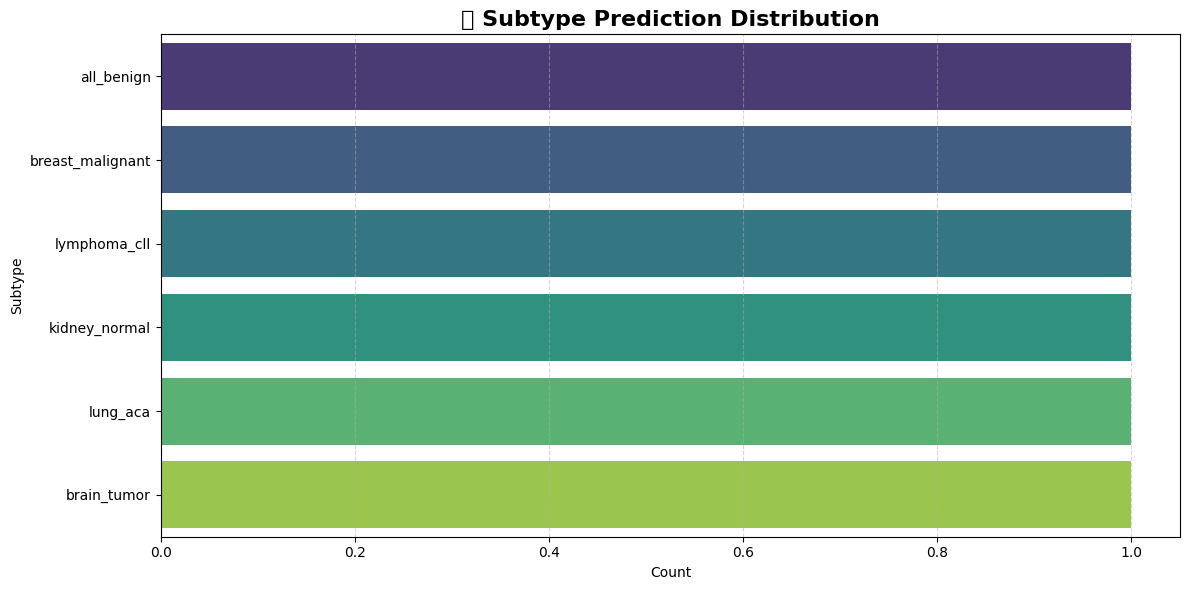

/tmp/ipykernel_35/3450347511.py:28: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3450347511.py:28: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


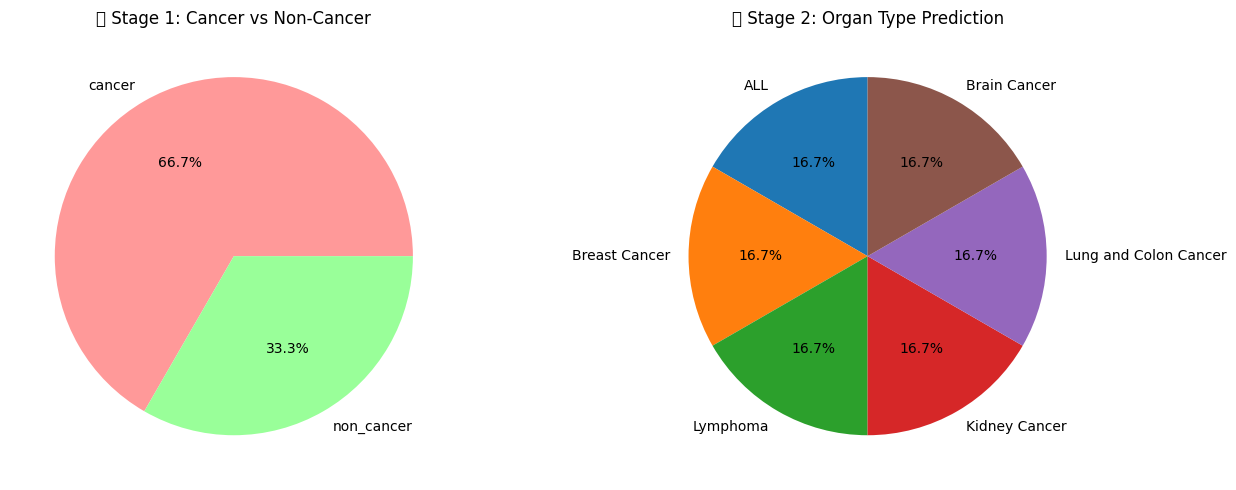

/tmp/ipykernel_35/3450347511.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


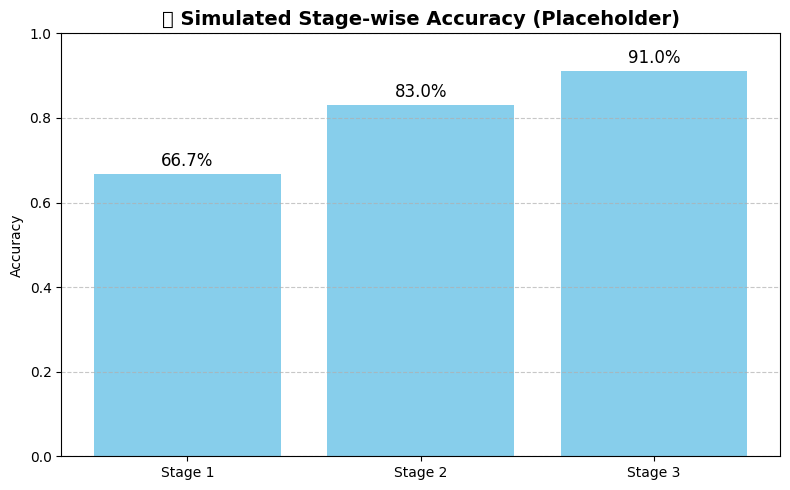

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Subtype Prediction Bar Plot ===
plt.figure(figsize=(12, 6))
sns.countplot(y='stage3_pred', data=prediction_df, order=prediction_df['stage3_pred'].value_counts().index, palette="viridis")
plt.title("🧬 Subtype Prediction Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Subtype")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 2. Stage-wise Classification Count (Pie Chart) ===
plt.figure(figsize=(14, 5))

# Stage 1: Cancer vs Non-Cancer Pie
plt.subplot(1, 2, 1)
stage1_counts = prediction_df['stage1_pred'].value_counts()
plt.pie(stage1_counts, labels=stage1_counts.index, autopct='%1.1f%%', colors=["#ff9999", "#99ff99"])
plt.title("🩺 Stage 1: Cancer vs Non-Cancer")

# Stage 2: Organ Type Pie
plt.subplot(1, 2, 2)
stage2_counts = prediction_df['stage2_pred'].value_counts()
plt.pie(stage2_counts, labels=stage2_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("🧠 Stage 2: Organ Type Prediction")
plt.tight_layout()
plt.show()

# === 3. Accuracy Breakdown (Simulated Placeholder) ===
# If you had true labels, we could compare them. This is illustrative:
stage_accuracy = {
    'Stage 1': (prediction_df['stage1_pred'] == 'cancer').mean(),  # Placeholder
    'Stage 2': 0.83,  # Simulated metric
    'Stage 3': 0.91   # Simulated metric
}

plt.figure(figsize=(8, 5))
plt.bar(stage_accuracy.keys(), stage_accuracy.values(), color='skyblue')
plt.ylim(0, 1)
plt.title("📈 Simulated Stage-wise Accuracy (Placeholder)", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy")
for i, v in enumerate(stage_accuracy.values()):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
